### Multiple Layers Perceptron

Import libraries and define some constants.

In [15]:
import scipy.io as scio  
import numpy as np 
import tensorflow as tf
  
TRAIN_DATA_PATH = './train_test/train_data.mat' 
TRAIN_LABEL_PATH = './train_test/train_label.mat' 
TEST_DATA_PATH = './train_test/test_data.mat' 
TEST_LABEL_PATH = './train_test/test_label.mat' 

LEARNING_RATE = 0.01
TRAINING_EPOCHS = 200
BATCH_SIZE = 100
DISPLAY_STEP = 5

BETA = 0.01

INPUT_LAYERS_D = 310
HIDDEN_LAYERS_D = 20
OUTPUT_LAYERS_D = 3 

Load data and preprocess the label to one-hot representation.

In [16]:
# type: numpy.ndarray
train_data = scio.loadmat(TRAIN_DATA_PATH)['train_data']
train_label = scio.loadmat(TRAIN_LABEL_PATH)['train_label']
test_data = scio.loadmat(TEST_DATA_PATH)['test_data']
test_label = scio.loadmat(TEST_LABEL_PATH)['test_label']

# Transfrom label to one-hot representation
train_label = [x[0] + 1 for x in train_label]
train_label = tf.one_hot(train_label, depth = 3, on_value=None, off_value=None, axis=None, dtype=None, name=None)

test_label = [x[0] + 1 for x in test_label]
test_label = tf.one_hot(test_label, depth = 3, on_value=None, off_value=None, axis=None, dtype=None, name=None)

with tf.Session() as sess:
    train_label = sess.run(train_label)
    test_label = sess.run(test_label)
    
# normalize the train and test data
def normalize(X):
    mean = X.mean(axis=0)
    var = X.std(axis=0)
    return (X - mean) / var, mean, var

train_data, train_mean, train_var = normalize(train_data)
test_data = (test_data - train_mean) / train_var

In [17]:
# tf Graph input
X = tf.placeholder("float", [None, INPUT_LAYERS_D])
Y = tf.placeholder("float", [None, OUTPUT_LAYERS_D])

# Store layers weight & bias
weight = {
    'h': tf.Variable(tf.random_normal([INPUT_LAYERS_D, HIDDEN_LAYERS_D])),
    'out': tf.Variable(tf.random_normal([HIDDEN_LAYERS_D, OUTPUT_LAYERS_D]))
}
bias = {
    'h': tf.Variable(tf.zeros([HIDDEN_LAYERS_D])),
    'out': tf.Variable(tf.zeros([OUTPUT_LAYERS_D]))
}

Create model

In [18]:
def multilayer_perceptron(x, weight, bias):
    hidden_layer = tf.add(tf.matmul(x, weight['h']), bias['h'])
    hidden_layer = tf.nn.relu(hidden_layer)

    out_layer = tf.matmul(hidden_layer, weight['out']) + bias['out']

    return out_layer

In [19]:
# Model
model = multilayer_perceptron(X, weight, bias)

# Loss Function with l2 regularization
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y) + \
                     tf.nn.l2_loss(weight['h']) + \
                     tf.nn.l2_loss(weight['out']) + \
                     tf.nn.l2_loss(bias['h']) + \
                     tf.nn.l2_loss(bias['out']))

# Adam Optimizer (or GradientDescentOptimizer)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

In [20]:
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    loss_vec = []
    
    # Training cycle
    for epoch in range(TRAINING_EPOCHS):
        avg_cost = 0.
        total_batch = int(train_data.shape[0] / BATCH_SIZE)

        for i in range(total_batch):
            batch_x = train_data[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
            batch_y = train_label[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
            
        
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, loss], feed_dict={X: batch_x, Y: batch_y})
            
            # Compute average loss
            avg_cost += c / total_batch

        loss_vec.append(avg_cost)
        
        # Display logs per epoch step
        if epoch % DISPLAY_STEP == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "Training Loss={:.9f}".format(avg_cost))

    print("Optimization Finished!")
    
    # Test model
    pred = tf.nn.softmax(model)  # Apply softmax to logits
    correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print("Test Accuracy:", accuracy.eval({X: test_data, Y: test_label}))

Epoch: 0001 Training Loss=3101.429687500
Epoch: 0006 Training Loss=2279.263305664
Epoch: 0011 Training Loss=1658.153289795
Epoch: 0016 Training Loss=1209.387878418
Epoch: 0021 Training Loss=886.836029053
Epoch: 0026 Training Loss=653.780197144
Epoch: 0031 Training Loss=484.298896790
Epoch: 0036 Training Loss=360.333839417
Epoch: 0041 Training Loss=269.188430786
Epoch: 0046 Training Loss=201.853725433
Epoch: 0051 Training Loss=151.909801483
Epoch: 0056 Training Loss=114.718196869
Epoch: 0061 Training Loss=86.922304153
Epoch: 0066 Training Loss=66.074010849
Epoch: 0071 Training Loss=50.380745888
Epoch: 0076 Training Loss=38.540727615
Epoch: 0081 Training Loss=29.586069584
Epoch: 0086 Training Loss=22.798184872
Epoch: 0091 Training Loss=17.639370918
Epoch: 0096 Training Loss=13.709613800
Epoch: 0101 Training Loss=10.711270332
Epoch: 0106 Training Loss=8.416409492
Epoch: 0111 Training Loss=6.660131335
Epoch: 0116 Training Loss=5.312017679
Epoch: 0121 Training Loss=4.275822282
Epoch: 0126 T

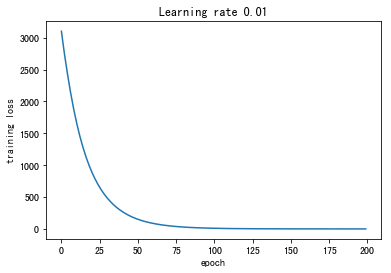

In [21]:
# Plot the loss graph
import matplotlib.pyplot as plt
% matplotlib inline

plt.plot(loss_vec)
plt.title('Learning rate {}'.format(LEARNING_RATE))
plt.ylabel('training loss')
plt.xlabel('epoch')
plt.show()
# plt.savefig('./training_loss.png', dpi=200)